# Проект: вариант 2

Вы – единственный аналитик в компании, на которого легла ответственность за поиск инсайтов в данных продуктовых магазинов вашей компании. На повестке 3 задачи:

## Задание 1

В файле test1_completed.csv содержится информация о покупках людей
* id – означает покупку (в одну покупку входят все товары, купленные пользователем во время 1 похода в магазин)
* Товар – наименование товара
* Количество – число единиц купленного товара

Воспользуйтесь этими данными и выясните, какие пары товаров пользователи чаще всего покупают вместе. По сути, вам необходимо найти паттерны покупок, что позволит оптимизировать размещение продуктов в магазине, для удобства пользователей и увеличения выручки.
* 1_Товар – наименование первого товара
* 2_Товар – наименование второго товара
* Встречаемость – число раз, когда такая пара была встречена
Другими словами: 2 раза люди покупали одновременно чай и арбуз, 1 раз одновременно покупали арбуз и сгущёнку и 1 раз одновременно были куплены чай со сгущёнкой.

Напишите код на python для получения нужной таблицы и укажите 5 наиболее распространённых паттернов.


1. Импорт библиотек

In [1]:
import pandas as pd
import os
from itertools import combinations

import numpy as np
import pandahouse as ph
from datetime import date
from fbprophet import Prophet

import seaborn as sns


In [2]:
os.getcwd()

'/home/jupyter-k.ezdakova-3/final_project'

2. Прописываем путь до файла и считываем данные

In [3]:
path_1 = '/home/jupyter-k.ezdakova-3/final_project/test1_completed.csv'

In [4]:
purchases = pd.read_csv(path_1)

3. Предподготовка данных

In [5]:
# Вывод 5 первых строк таблицы
purchases.head()

,id,Товар,Количество
0,17119,Лимон,1.1
1,17119,Лимон оранжевый,0.7
2,17119,Лук-порей,10.0
3,17119,Лук репчатый,2.5
4,17119,Малина свежая,1.0


In [6]:
print('Размер таблицы с данными:', purchases.shape)

Размер таблицы с данными: (43514, 3)


In [7]:
print('Есть ли нули в каждом столбце:', purchases.isnull().any(), sep='\n')

Есть ли нули в каждом столбце:
id            False
Товар         False
Количество    False
dtype: bool


In [8]:
print('Количество уникальных значений в каждом столбце:', purchases.nunique(), sep='\n')

Количество уникальных значений в каждом столбце:
id            3273
Товар          199
Количество     101
dtype: int64


In [9]:
# Переименование названия столюцов для удобства
purchases = purchases.rename(columns={'Товар':'Product', 'Количество':'Quantity'})

In [10]:
purchases.head()

,id,Product,Quantity
0,17119,Лимон,1.1
1,17119,Лимон оранжевый,0.7
2,17119,Лук-порей,10.0
3,17119,Лук репчатый,2.5
4,17119,Малина свежая,1.0


4. Анализ данных

Воспользуйтесь этими данными и выясните, какие пары товаров пользователи чаще всего покупают вместе. 
Для этого необходимо получить таблицу со столбцами

* 1_Товар – наименование первого товара
* 2_Товар – наименование второго товара
* Встречаемость – число раз, когда такая пара была встречена 


In [11]:
# Создание функции для получения комбинаций для каждой покупки
def get_combinations(id_purchase):
    products = id_purchase.sort_values().values
    combs = list(combinations(products, 2))
    return combs

In [12]:
# Таблица парных комбинаций
combination_of_2_products = purchases.groupby('id', as_index=False) \
                                    .agg({'Product': get_combinations}) \
                                    .rename(columns={'Product': 'combination'}) \
                                    .explode('combination', ignore_index=True)
combination_of_2_products.head()


,id,combination
0,17119,"(Лимон, Лимон оранжевый)"
1,17119,"(Лимон, Лук репчатый)"
2,17119,"(Лимон, Лук-порей)"
3,17119,"(Лимон, Малина свежая)"
4,17119,"(Лимон, Морковь немытая)"


In [15]:
combination_of_2_products[['product_1','product_2']] = pd.DataFrame(combination_of_2_products['combination'].tolist(),\
                                                                    index=combination_of_2_products.index)
combination_of_2_products.head()

,id,combination,product_1,product_2
0,17119,"(Лимон, Лимон оранжевый)",Лимон,Лимон оранжевый
1,17119,"(Лимон, Лук репчатый)",Лимон,Лук репчатый
2,17119,"(Лимон, Лук-порей)",Лимон,Лук-порей
3,17119,"(Лимон, Малина свежая)",Лимон,Малина свежая
4,17119,"(Лимон, Морковь немытая)",Лимон,Морковь немытая


In [16]:
combination_of_2_products.drop(columns=['combination'], inplace=True)
combination_of_2_products.head()

,id,product_1,product_2
0,17119,Лимон,Лимон оранжевый
1,17119,Лимон,Лук репчатый
2,17119,Лимон,Лук-порей
3,17119,Лимон,Малина свежая
4,17119,Лимон,Морковь немытая


In [20]:
# Создаем таблицу парных покупок продуктов
pair_products = combination_of_2_products.groupby(['product_1','product_2'])\
    .agg({'id':'count'})\
    .rename(columns={'id':'occurrence'})\
    .sort_values('occurrence', ascending=False).head()

pair_products.head()

,,occurrence
product_1,product_2,
Огурцы Луховицкие,Укроп,431
Петрушка,Укроп,408
Арбуз,Огурцы Луховицкие,345
Кабачки,Огурцы Луховицкие,326
Кинза,Укроп,303


In [21]:
top_5_pair_products = pair_products.reset_index().head(5)

In [22]:
print('Топ 5 самых покупаемых товаров вместе:',  top_5_pair_products, sep='\n')

Топ 5 самых покупаемых товаров вместе:
           product_1          product_2  occurrence
0  Огурцы Луховицкие              Укроп         431
1           Петрушка              Укроп         408
2              Арбуз  Огурцы Луховицкие         345
3            Кабачки  Огурцы Луховицкие         326
4              Кинза              Укроп         303


In [23]:
# Выгружаем в эксель. 
top_5_pair_products.to_excel("./top5_pair.xlsx", sheet_name='Data', index=False, encoding="cp1251")

### Задание 2¶
К вам поступила информация о числе заказов за прошедшие 3 месяца с разрешением по неделям. Постройте (если это возможно) прогноз продаж на следующие 3 месяца, с учётом того, что в неделю с 2020-02-02 по 2020-02-09 была проведена массивная акция, повысившая число заказов на 7% Данные в test2_completed.csv

В публикации Sean J. Taylor, Benjamin Letham "Forecasting at scale" представлено и сравнение mean absolute percentage error (MAPE) для различных методов автоматического прогнозирования временных рядов, согласно которому Prophet имеет существенно более низкую ошибку.

Prophet оптимизирован для задач бизнес-прогнозирования, которые обычно обладают любой из следующих характеристик:

* ежечасные, ежедневные или еженедельные наблюдения с историей не менее нескольких месяцев (предпочтительно года)
* сильная множественная сезонность «человеческого масштаба»: день недели и время года
* важные праздники, которые происходят с нерегулярными интервалами, о которых заранее известно
* разумное количество отсутствующих наблюдений или больших выбросов
* исторические изменения тенденции, например, из-за запуска продукта или регистрации изменений
* тренды, которые представляют собой нелинейные кривые роста, когда тренд достигает естественного предела или достигает насыщения




1. Загружаем данные

In [21]:
path_2 = '/home/jupyter-k.ezdakova-3/final_project/test2_completed.csv'

In [22]:
orders = pd.read_csv(path_2)
orders.head()

,Дата,Число заказов
0,2020-01-05,650
1,2020-01-12,837
2,2020-01-19,1020
3,2020-01-26,1176
4,2020-02-02,1489


2. Переименовываем столбцы, для возможности дальнейшего прогнозирования при помощи Prophet

In [24]:
orders.rename(columns={'Дата':'ds', 'Число заказов':'y'}, inplace=True)

3. Изменяем тип данных столбца ds на временной

In [25]:
orders['ds'] = pd.to_datetime(orders.ds)

In [26]:
orders.tail()

,ds,y
9,2020-03-08,2607
10,2020-03-15,2734
11,2020-03-22,3492
12,2020-03-29,3608
13,2020-04-05,3857


In [8]:
orders.dtypes

ds    datetime64[ns]
y              int64
dtype: object

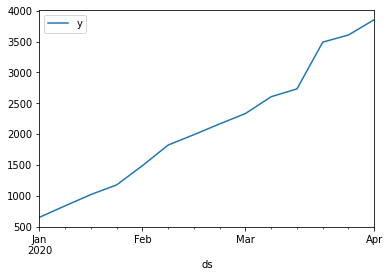

In [30]:
orders.plot(x='ds', y='y')

В данном случае дан временной ряд, содержащий информацию о еженедельных количествах заказов. Также известно об акции, повысившей число заказов в неделю с 2020-02-02 по 2020-02-09. Из рисунка виден линейный тренд в данных.

In [31]:
# Период, который надо отрезать и предсказать (проверка модели)
predictions = 5

# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество
train_df = orders[:-predictions]

In [32]:
import holidays
# Вкидываем праздники, для их учёта моделькой
holidays_dict = holidays.RU(years=(2015, 2016, 2017, 2018, 2019, 2020, 2021))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index') \
    .reset_index()
df_holidays = df_holidays.rename({'index':'ds', 0:'holiday'}, axis ='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)
df_holidays.tail()

,ds,holiday
93,2021-03-08,День женщин
94,2021-05-01,Праздник Весны и Труда
95,2021-05-09,День Победы
96,2021-06-12,День России
97,2021-11-04,День народного единства


In [33]:
m = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False,\
            changepoints='2020-02-09')
m.fit(train_df)

In [34]:
# Предсказываем 
future = m.make_future_dataframe(periods=5, freq='w')
forecast = m.predict(future)

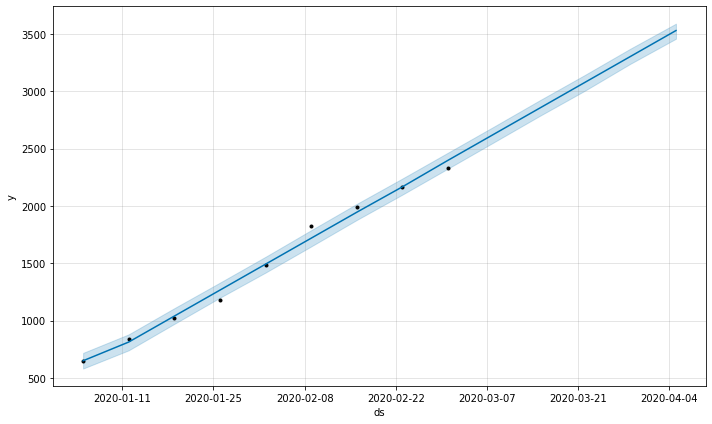

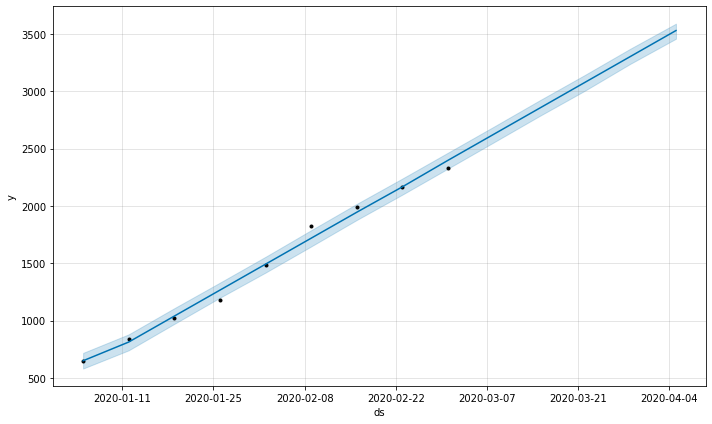

In [35]:
# Смотрим, что предсказалось
m.plot(forecast)

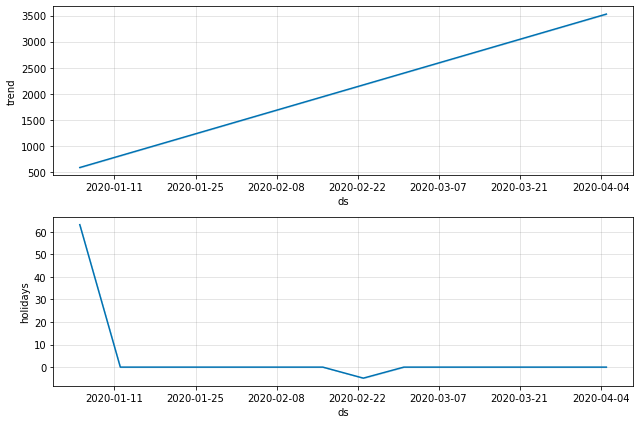

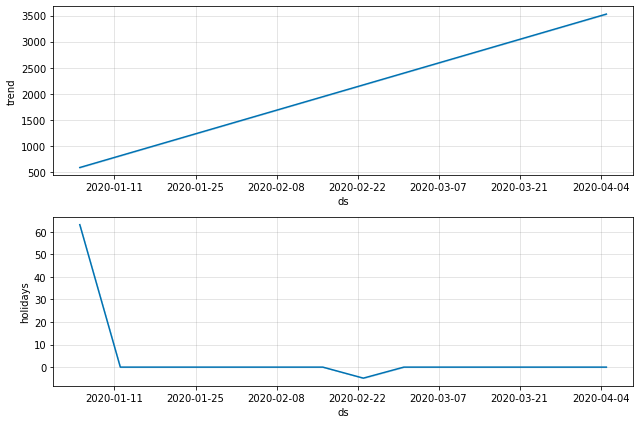

In [14]:
# Смотрим на сезонности
m.plot_components(forecast)

In [36]:
# Смотрим на ошибки модели
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(orders.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  6.7495404182926135 %
MAE (средняя абсолютная ошибка) –  236.28501618026422


In [39]:
# Прогнозируем на полный период (указываем количество дней)
final_train_df = orders
f = Prophet( daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False,\
            changepoints='2020-02-09')
f.fit(final_train_df)
final_future = f.make_future_dataframe(periods=13, freq='w')
final_forecast = f.predict(final_future)

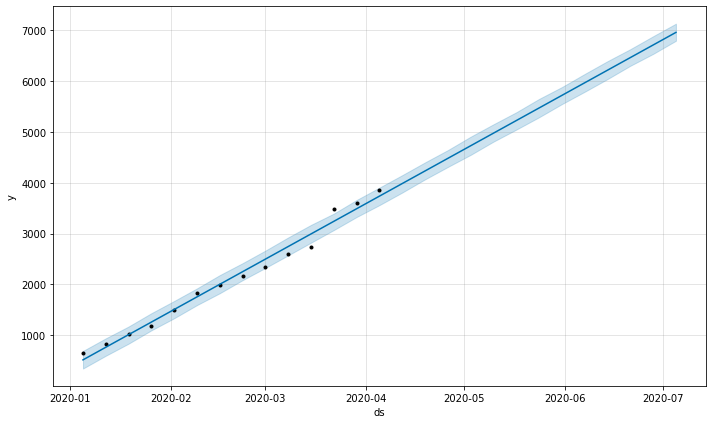

In [40]:
# Смотрим, что предсказалось на полный период
f.plot(final_forecast);

### Результаты и выводы.

Прогнозирование временного ряда было выполнено, как математический эксперимет, безотносительно реальности процессов. Полученный линейный тренд хорошо согласуется с трендом в изначальных данных. Cредняя абсолютная ошибка в процентах составляет 6.75 % что означает, что модель может ошибаться в среднем на 6,7%.
Но есть несколько моментов, которые мешают сказать, что полученный прогноз - хороший. 
1. Данных на которых модель учится - мало, что сказывается на качестве модели. Из-за этого сложно учесть сезонность помесячную, и невозможно поквартальную и годовую.
2. Период, на который требуется предсказать количество заказов, равен периоду, на котором основывается модель, что тоже не очень хорошо. 
3. Из условия задания предполагается, что речь идет о каком-то продукте, предоставлюящим услуги или товары, и в том и в другом случае количество заказов не может быть бесконечным, в виду ограниченности количества пользователей и насыщаемости рынка. В таком случае следует использовать тренд с насыщением(логистическую регрессию), но никакой информации о естественной емкости системы у нас нет. 

### Вывод

Математически спрогнозировать можно, но такой прогноз окажется не точным по указанным выше причинам, не смотря на полученное значение средней абсолютной ошибки 6.75 %.



### Задание 3
В базе данных вашей компании присутствуют следующие таблицы
##### city 
* city_id – id города, где проходит акция 
* client_city_id – id города, где находится покупатель 
* city – город client_city – город, где находится покупатель 

##### client 
* client_id – id покупателя 
* client_city_id – id города, где находится покупатель 
* birth_date – дата рождения покупателя 
* registration – дата регистрации покупателя 

##### promotion 
* promotion_id – id акции 
* category_id – id категории 
* promotion_name – акция 
* category_name – категория 
* partner_id – id партнёра 
* partner_name – партнёр 

##### purchase 
* purchase_id – id покупки 
* partner_id – id партнёра 
* client_id – id покупателя 
* city_id – id города 
* promotion_id – id акции 
* category_id – id категории 
* purchase_date – дата покупки 
* price – цена за единицу товара 
* quantity – число проданных единиц 
* status – статус покупки 

Вам нужно написать запрос, чтобы получить такую таблицу

* purchase_date – дата покупки 
* purchase_id – id покупки 
* client_id – id покупателя 
* client_age – возраст покупателя 
* client_registration_age – как долго человек пользуется вашими магазинами 
* client_category – содержит new или old, если это первая или последующая покупка соответственно 
* promotion_name – акция 
* category_name – категория 
* partner_name – партнёр 
* client_city – город, где находится покупатель 
* city – город 
* revenue – сумма выручки 
* quantity – число проданных единиц 

При этом в таблице должны присутствовать только значения, где в поле status стоит значение 1, и только те, где purchase_date находится в диапазоне от 01.05.2020 до 01.08.2020

База данных доступна по имени project_variant_2

1. Создаем соединение с этой базой данных

In [41]:
connection_project_variant_2 = {'host': 'http://clickhouse.beslan.pro:8080',
                                'database':'project_variant_2',
                                'user':'student', 
                                'password':'dpo_python_2020'
                                }

2. Пишем запрос для получения необходимой по заданию таблицы

In [42]:
query = """
SELECT 
   CAST(a.purchase_date AS Date) AS purchase_date,
   a.purchase_id AS purchase_id,
   a.client_id AS client_id,
   dateDiff('year', d.birth_date, today()) AS client_age,
   dateDiff('month', d.registration, today()) AS client_registration_age,
   e.client_category AS client_category,
   c.promotion_name AS promotion_name,
   c.category_name AS category_name,
   c.partner_name AS partner_name,
   b.client_city AS client_city,
   b.city AS city,
   toInt8(a.quantity)*toInt16(a.price) AS revenue,
   toInt8(a.quantity) AS quantity
FROM project_variant_2.purchase AS a
JOIN project_variant_2.city AS b

ON a.city_id = b.city_id

JOIN project_variant_2.promotion AS c

ON a.promotion_id = c.promotion_id

JOIN project_variant_2.client AS d

ON d.client_id = a.client_id

JOIN (SELECT 
             DISTINCT client_id,
             count(client_id),
             if( toUInt8(count(client_id)-1), 'old', 'new') AS client_category
      
      FROM project_variant_2.purchase

      GROUP BY client_id) AS e

ON e.client_id = a.client_id



WHERE a.status = 1 
    AND a.purchase_date > '2020-05-01' 
    AND a.purchase_date < '2020-08-01'


"""
df = ph.read_clickhouse(query=query, connection=connection_project_variant_2)
df.head()

,purchase_date,purchase_id,client_id,client_age,client_registration_age,client_category,promotion_name,category_name,partner_name,client_city,city,revenue,quantity
0,2020-06-05,0,853,28,18,old,campaign_2,Фрукты,"ООО Ширяева, Хохлова и Тимофеева",Щучинщина,Киев,150,5
1,2020-06-05,0,853,28,18,old,campaign_2,Фрукты,"ООО Ширяева, Хохлова и Тимофеева",Москва,Киев,150,5
2,2020-06-05,0,853,28,18,old,campaign_2,Фрукты,"ООО Ширяева, Хохлова и Тимофеева",Ярославль,Киев,150,5
3,2020-06-05,0,853,28,18,old,campaign_2,Фрукты,"ООО Ширяева, Хохлова и Тимофеева",Санкт-Петербург,Киев,150,5
4,2020-06-05,0,853,28,18,old,campaign_2,Фрукты,"ООО Ширяева, Хохлова и Тимофеева",Новгород,Киев,150,5


3. Сохраняем полученную таблицу в Эксель

In [43]:
# Выгружаем в эксель. 
df.to_excel("./data.xlsx", sheet_name='Data', index=False, encoding="cp1251")